# Simple data generation

This notebook explains how generate a GW signal (h+,hx, projected strain, TDI) from source parameters using the LDC toolbox and the different simulation tools (LISANode, lisa instrument, pyTDI) . 


## Software requirements

- git clone https://gitlab.in2p3.fr/LISA/LDC
- pip install requirements.txt
- python setup.py build_liborbits install

Look at the LDC README for more details.

Installation instructions for the various simulation tools can be found in the relevant README:
- https://gitlab.in2p3.fr/j2b.bayle/LISANode
- https://gitlab.in2p3.fr/lisa-simulation


## Generating a Galactic binary signal

In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import xarray as xr
from astropy import units as u
import pandas as pd

import ldc.io.hdf5 as hdfio
from ldc.waveform.source import load_gb_catalog, load_mbhb_catalog
from ldc.lisa.noise import get_noise_model


from ldc.common.series import TimeSeries, FrequencySeries

from ldc.common.tools import compute_tdi_snr, window


/usr/lib/python3.9/typing.py:984: FutureWarning: xarray subclass TDI should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


Let's use a verification binary from the catalog provided by the LDC software

In [2]:
cat, units = load_gb_catalog("../data_generation/test/data/VGB.npy", rename=True)
pd.DataFrame(cat)

,Name,Amplitude,EclipticLatitude,EclipticLongitude,Frequency,FrequencyDerivative,Inclination,InitialPhase,Polarization
0,AM_CVn,2.829120e-22,0.653451,2.973870,0.001944,6.489726e-18,1.047198,3.006892,2.117236
1,CD-30o11223,4.150747e-21,-0.289986,3.860292,0.000473,1.440030e-19,1.446878,1.700000,1.700000
2,CR_Boo,2.935934e-22,0.312414,-2.752910,0.001360,9.622534e-18,0.523599,3.058156,3.562166
3,CXOGBS_J175107.6,4.223900e-23,-0.109131,4.678555,0.001455,1.230880e-18,1.047198,0.900000,0.900000
4,ES_Cet,1.068900e-22,-0.354825,0.429700,0.003221,5.536807e-17,1.616935,2.840901,2.532922
5,HM_Cnc,6.378230e-23,-0.082205,2.102250,0.006220,7.485286e-16,0.645772,3.171656,2.916178
6,HP_Lib,1.762760e-22,0.086568,-2.180090,0.001813,2.049740e-18,0.523599,2.974591,3.619093
7,PTF1_J191905.19+481506.2,3.201751e-23,1.204785,5.393106,0.001484,1.366448e-18,1.047198,0.800000,0.800000
8,SDSS_J065133.34+284423.4,1.619054e-22,0.101340,1.768676,0.002613,2.627231e-17,1.516691,1.200000,1.200000
9,SDSS_J092345.59+302805.0,2.638561e-22,0.251830,2.333754,0.000515,1.050732e-19,1.047198,1.500000,1.500000


We choose the 1st source and set observation parameters

In [3]:
from ldc.lisa.orbits import Orbits
config = {"initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic'}
lisa_orbits = Orbits.type(config)

t_max = 60*60*24*365
t_min = 0
dt = 15

s_index = 0 # take the first source
pGB = dict(zip(cat.dtype.names, cat[s_index]))
pd.DataFrame(cat).head(1)

,Name,Amplitude,EclipticLatitude,EclipticLongitude,Frequency,FrequencyDerivative,Inclination,InitialPhase,Polarization
0,AM_CVn,2.829120e-22,0.653451,2.97387,0.001944,6.489726e-18,1.047198,3.006892,2.117236


### Generating noise free TDI X,Y,Z using fast waveform generator

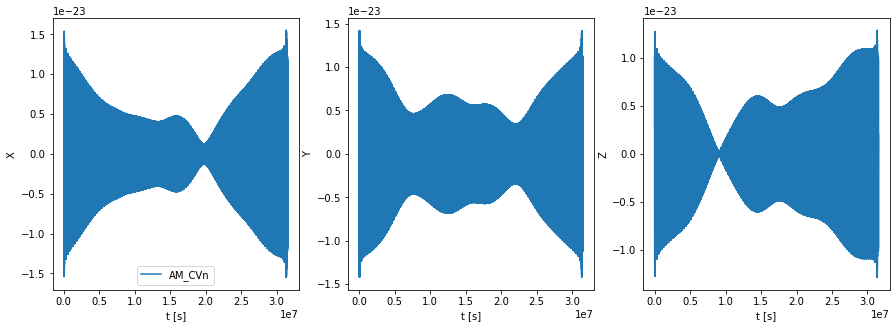

In [4]:
import ldc.waveform.fastGB as fastGB
GB = fastGB.FastGB(delta_t=dt, T=t_max, orbits=lisa_orbits) # in seconds
Xs, Ys, Zs = GB.get_td_tdixyz(template=pGB, oversample=4)

plt.figure(figsize=(15, 5))
for j, d in enumerate([Xs, Ys, Zs]):
    plt.subplot(1,3,j+1)
    d.plot(label=pGB['Name'])
    if j==0:
        plt.legend()

### Generating noise free projected strain

In the following, projector.yArm (nt, 6) contains the projected strain signal for the 6 links, it can be saved in an h5 file to be given as input to LISANode. The LISANode configuration file has to be changed for:

```
LISA_GW_TYPE = 'file'
LISA_GW_FILE_FS = 0.2 #1 over dt 
```

Then: ```lisanode run lisanode:LISAWithTDI --gw-path my_gw_for_lisanode.h5```

The actual call to lisanode is shown below. 

In [5]:
from ldc.lisa.projection import ProjectedStrain
from ldc.waveform.waveform import HpHc

GB = HpHc.type(pGB["Name"], "GB", "TD_fdot")
GB.set_param(pGB)
projector = ProjectedStrain(lisa_orbits)
yArm = projector.arm_response(t_min, t_max, dt, [GB])
projector.links

['1-2', '1-3', '2-1', '2-3', '3-1', '3-2']

In [6]:
projector.to_file("my_gw_for_lisanode.h5")

In [7]:
tdi_X = projector.compute_tdi_x(np.arange(t_min, t_max, dt))

### From projected strain to TDI

In the following, we illustrate 4 ways of producing noise free TDI from the projected strain: 
- using the LDC time domain interpolated TDI
- using pyTDI
- using LISANode
- using lisa instrument

which should all give the same result as the fast TDI code shown above. 

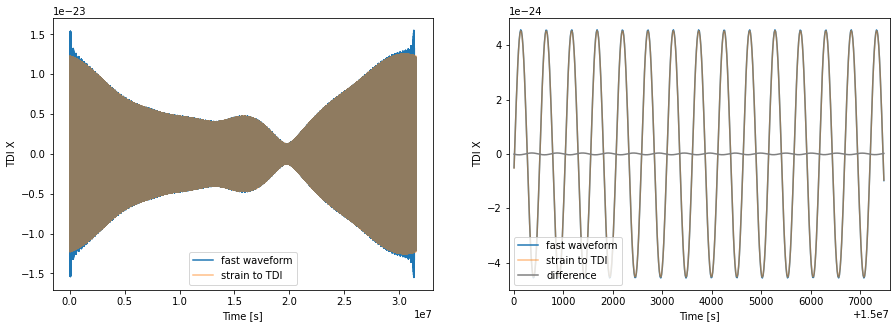

In [12]:
tdi_X = projector.compute_tdi_x(Xs.t.values)

plt.figure(figsize=(15,5))
plt.subplot(121)
Xs.plot(label="fast waveform")
plt.plot(Xs.t, tdi_X, label="strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.subplot(122)
sl = slice(1000000,1000500)
plt.plot(Xs.t[sl], Xs[sl], label="fast waveform")
plt.plot(Xs.t[sl], tdi_X[sl], label="strain to TDI", alpha=0.5)
plt.plot(Xs.t[sl], tdi_X[sl]-Xs[sl], label="difference", color='grey')
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.axis([Xs.t[sl.start]-100, Xs.t[sl.stop]+100, -0.5e-23, 0.5e-23])
plt.legend()

### Using pyTDI

In [14]:
from pytdi.michelson import X1_ETA as X
from pytdi import Data
data = {}
traveltimes = {}
trange = np.arange(projector.t_min, projector.t_max, projector.dt)
for j, n in enumerate(projector.links):
    r,s = int(n[0]), int(n[-1])
    data[f"eta_{r}{s}"] = yArm[:,j]
    traveltimes[f"d_{r}{s}"] = lisa_orbits.compute_travel_time(s,r,trange) 
fs = 1/dt
data = Data(data, traveltimes, fs)
build = X.build(**data.args_nodoppler)

In [16]:
data_X = build(data.measurements)

(1499900.0, 1507600.0, -1.5e-23, 1.2225321045182246e-23)

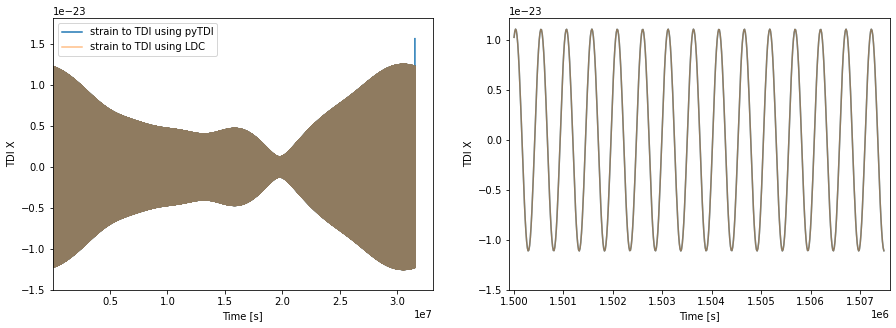

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(trange, data_X, label="strain to TDI using pyTDI")
plt.plot(trange, tdi_X, label="strain to TDI using LDC", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.axis([1000, None, -1.5e-23, None])
plt.legend()
plt.subplot(122)
sl = slice(100000,100500)
plt.plot(trange[sl], data_X[sl], label="strain to TDI using pyTDI")
plt.plot(trange[sl], tdi_X[sl], label="strain to TDI using LDC", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.axis([trange[sl.start]-100, trange[sl.stop]+100, -1.5e-23, None])

In [ ]:
del projector, yArm, tdi_X, X, traveltimes, data, data_X, trange

### Using lisa instrument 

TODO 

### Using lisa GW response

TODO

## Calling LISANode

### Note about Orbits

One should use the same orbits and travel time for the projection and in the simulator. 
For now, this can be achieved by:
- generating orbits file using the [lisaorbits](https://gitlab.in2p3.fr/lisa-simulation/orbits) software
- use it in LDC projector computation, by building orboys with this configuration ```config = {"nominal_arm_length": 2500000000, "orbit_type": 'file', "filename": 'orbits.h5'}```
- using the ```--orbit-path orbits.h5``` LISANode runtime option.


### Note about LISANode frequency sampling

For the time being, the LISANode compilation takes a lot of time and memory due to the sampling difference between input GW strain (0.2Hz) and LISA measurement (30Hz).  

One needs to upsample all input signal of LISANode at its measurement sampling to avoid this issue (this applies to GW strain and orbits file). 

## Generating a massive black hole merger signal

In [19]:
cat, units = load_mbhb_catalog("../data_generation/test/data/catalog_1_yrs_full_1.dat")
pd.DataFrame(cat)

,EclipticLatitude,EclipticLongitude,PolarAngleOfSpin1,PolarAngleOfSpin2,Spin1,Spin2,Mass1,Mass2,CoalescenceTime,PhaseAtCoalescence,InitialPolarAngleL,InitialAzimuthalAngleL,Redshift,Distance
0,0.421998,3.291052,2.168084,2.478092,0.892382,0.570879,298995.0,287572.0,3.409125e+07,3.077585,1.256483,1.657101,2.83462,24363.400645
1,-0.577548,5.184169,2.184452,1.997086,0.995335,0.649950,281818.0,253224.0,1.515612e+08,0.310313,1.189669,5.352838,4.28557,39850.421054
2,-0.119126,2.113727,0.369755,1.680277,0.972603,0.990541,323283.0,184307.0,1.406976e+08,5.105357,2.433856,3.566298,3.50842,31441.059699
3,0.789798,1.409669,2.608840,0.789381,0.780164,0.998000,412288.0,215113.0,2.789121e+07,1.573143,0.099662,0.970856,2.17677,17708.063739
4,-0.111478,2.487932,1.604502,0.889584,0.980288,0.998000,231400.0,129322.0,6.191659e+07,5.435507,0.931624,5.375956,6.58376,65778.518657
5,-0.256023,0.900975,1.872914,0.795166,0.998000,0.995156,293838.0,149465.0,2.839082e+07,1.437696,0.252361,4.250104,2.57128,21664.498198
6,1.083933,4.596217,0.789460,1.811009,0.998000,0.998000,177190.0,84137.0,3.132388e+07,4.433687,2.393751,4.932560,5.36542,51867.527208


In [21]:
dt = 5
s_index = 3 # take the fourth, which merge before 1 yr 
pMBHB = dict(zip(cat.dtype.names, cat[s_index]))
pMBHB["ObservationDuration"] = t_max
pMBHB["Cadence"] = dt
MBHB = HpHc.type("demo", "MBHB", "IMRPhenomD")
MBHB.set_param(pMBHB)
projector = ProjectedStrain(lisa_orbits)
yArm = projector.arm_response(t_min, t_max, dt, MBHB.split())
projector.to_file("my_mbhb_for_lisanode.h5")

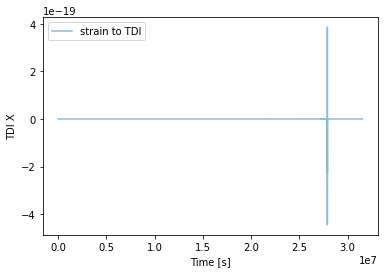

In [22]:
trange = np.arange(t_min, t_max, dt)
tdi_X = projector.compute_tdi_x(trange)

plt.figure()
plt.plot(trange, tdi_X, label="strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()